In [1]:
import os
import time
import pandas as pd
import numpy as np
import math
import pyspark

from sklearn.model_selection import train_test_split

# keras/tensorflow imports
from tensorflow.keras.layers import Input, Embedding, Flatten, Dense, Multiply, Concatenate
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model
# from tensorflow.keras.optimizers import Adagrad, Adam, SGD, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow.keras.backend as K
from tensorflow.keras.models import load_model

import matplotlib.pyplot as plt

In [2]:
# Read in the data

anime_data = pd.read_csv('assignment_2_anime.csv')
ratings_train = pd.read_csv('assignment_2_ratings_train.csv')
ratings_test = pd.read_csv('assignment_2_ratings_test.csv')

## Neural network based Collaborative Filtering

### Generalized Matrix Factorization

In [3]:
num_users = len(ratings_train.user_id.unique())
num_items = len(ratings_train.anime_id.unique())

In [4]:
def get_GMF_model(num_users, num_items, latent_dim, vu_reg, vi_reg):
    """
    Build Generalized Matrix Factorization Model Topology
    
    Parameters
    ----------
    num_users: int, total number of users
    num_iterms: int, total number of items
    latent_dim: int, embedded dimension for user vector and item vector
    vu_reg: float, L2 regularization of user embedded layer
    vi_reg: float, L2 regularization of item embedded layer

    Return
    ------
    A Keras Model with GMF model architeture
    """
    # Input variables
    user_input = Input(shape=(1,), dtype='int32', name='user_input')
    item_input = Input(shape=(1,), dtype='int32', name='item_input')

    MF_Embedding_User = Embedding(
        input_dim=num_users + 1,
        output_dim=latent_dim,
        embeddings_initializer='uniform',
        name='user_embedding',
        embeddings_regularizer=l2(vu_reg),
        input_length=1)
    MF_Embedding_Item = Embedding(
        input_dim=num_items + 1,
        output_dim=latent_dim,
        embeddings_initializer='uniform',
        name='item_embedding',
        embeddings_regularizer=l2(vi_reg),
        input_length=1) 
    
    # Crucial to flatten an embedding vector!
    user_latent = Flatten()(MF_Embedding_User(user_input))
    item_latent = Flatten()(MF_Embedding_Item(item_input))

    # Element-wise product of user and item embeddings 
    predict_vector = Multiply()([user_latent, item_latent])
    
    # Final prediction layer
    prediction = Dense(1, kernel_initializer='glorot_uniform', name='prediction')(predict_vector)
    
    # Stitch input and output
    model = Model([user_input, item_input], prediction)
    
    return model


def train_model(model, learner, batch_size, epochs, val_split, inputs, outputs):
    """
    define training routine, train models and save best model
    
    Parameters
    ----------
    model: a Keras model
    learner: str, one of ['sgd', 'adam', 'rmsprop', 'adagrad']
    batch_size: num samples per update
    epochs: num iterations
    val_split: split ratio for validation data
    inputs: inputs data
    outputs: outputs data
    """
    # add customized metric
    def mse(y_true, y_pred):
        return K.mean(K.square(y_true - y_pred))
    
    # compile model
    model.compile(optimizer=learner.lower(), loss='mean_squared_error', metrics=['mean_squared_error', mse])
    
    # add call backs
    early_stopper = EarlyStopping(monitor='val_mse', patience=10, verbose=1)
    
    # train model
    history = model.fit(inputs, outputs,
                        batch_size=batch_size,
                        epochs=epochs,
                        validation_split=val_split,
                        callbacks=[early_stopper])
    return history


def load_trained_model(model, weights_path):
    model.load_weights(weights_path)
    return model

In [5]:
GMF_model = get_GMF_model(num_users, num_items, 10, 0, 0)
GMF_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user_input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
item_input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
user_embedding (Embedding)      (None, 1, 10)        684220      user_input[0][0]                 
__________________________________________________________________________________________________
item_embedding (Embedding)      (None, 1, 10)        96330       item_input[0][0]                 
______________________________________________________________________________________________

In [6]:
# model config
BATCH_SIZE = 64
EPOCHS = 5
VAL_SPLIT = 0.20

# train model
history = train_model(GMF_model, 'adam', BATCH_SIZE, EPOCHS, VAL_SPLIT, 
                      inputs=[ratings_train.user_id.values, ratings_train.anime_id.values],
                      outputs=ratings_train.rating.values)

Epoch 1/5
55451/55451 [==============================] - 233s 4ms/step - loss: 5.2335 - mean_squared_error: 5.2335 - mse: 5.2335 - val_loss: 1.9491 - val_mean_squared_error: 1.9491 - val_mse: 1.9491
Epoch 2/5
55451/55451 [==============================] - 246s 4ms/step - loss: 1.8760 - mean_squared_error: 1.8760 - mse: 1.8760 - val_loss: 1.8808 - val_mean_squared_error: 1.8808 - val_mse: 1.8808
Epoch 3/5
55451/55451 [==============================] - 233s 4ms/step - loss: 1.7908 - mean_squared_error: 1.7908 - mse: 1.7908 - val_loss: 1.8654 - val_mean_squared_error: 1.8654 - val_mse: 1.8654
Epoch 4/5
55451/55451 [==============================] - 232s 4ms/step - loss: 1.7402 - mean_squared_error: 1.7402 - mse: 1.7402 - val_loss: 1.8638 - val_mean_squared_error: 1.8638 - val_mse: 1.8638
Epoch 5/5
55451/55451 [==============================] - 232s 4ms/step - loss: 1.7100 - mean_squared_error: 1.7100 - mse: 1.7100 - val_loss: 1.8643 - val_mean_squared_error: 1.8643 - val_mse: 1.8643


In [7]:
def plot_learning_curve(history, metric):
    """
    Plot learning curve to compare training error vs. validation error
    """
    # get training error
    errors = history.history[metric]
    # get validation error
    val_errors = history.history['val_{}'.format(metric)]
    # get epochs
    epochs = range(1, len(errors) + 1)

    # plot
    plt.figure(figsize=(12, 7))
    plt.plot(epochs, errors, 'bo', label='training {}'.format(metric))
    plt.plot(epochs, val_errors, 'b', label='validation {}'.format(metric))
    plt.xlabel('number of epochs')
    plt.ylabel(metric)
    plt.title('Model Learning Curve')
    plt.grid(True)
    plt.legend()
    plt.show()

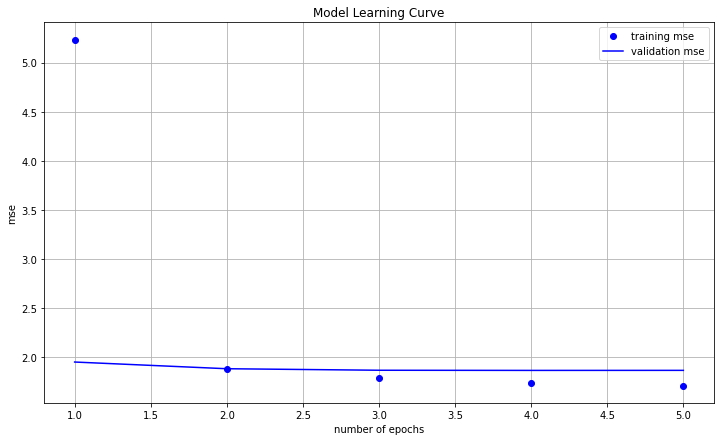

In [8]:
plot_learning_curve(history, 'mse')

In [11]:
mse = lambda true, pred: np.mean(np.square(np.squeeze(predictions) - np.squeeze(ratings_test.rating.values)))

predictions = GMF_model.predict([ratings_test.user_id.values, ratings_test.anime_id.values])
# get the RMSE
error = mse(ratings_test.rating.values, predictions)
print('The out-of-sample MSE of rating predictions is', round(error, 4))

The out-of-sample MSE of rating predictions is 1.8628


In [12]:
def get_MLP_model(num_users, num_items, layers, reg_layers):
    """
    Build Multi-Layer Perceptron Model Topology
    
    Parameters
    ----------
    num_users: int, total number of users
    num_iterms: int, total number of items
    layers: list of int, each element is the number of hidden units for each layer,
        with the exception of first element. First element is the sum of dims of
        user latent vector and item latent vector
    reg_layers: list of int, each element is the L2 regularization parameter for
        each layer in MLP

    Return
    ------
    A Keras Model with MLP model architeture
    """
    assert len(layers) == len(reg_layers)
    num_layer = len(layers) # Number of layers in the MLP
    # Input variables
    user_input = Input(shape=(1,), dtype='int32', name='user_input')
    item_input = Input(shape=(1,), dtype='int32', name='item_input')

    MLP_Embedding_User = Embedding(
        input_dim=num_users + 1,
        output_dim=layers[0] // 2,
        embeddings_initializer='uniform',
        name='user_embedding',
        embeddings_regularizer=l2(reg_layers[0]),
        input_length=1)
    MLP_Embedding_Item = Embedding(
        input_dim=num_items + 1,
        output_dim=layers[0] // 2,
        embeddings_initializer='uniform',
        name='item_embedding',
        embeddings_regularizer=l2(reg_layers[0]),
        input_length=1) 
    
    # Crucial to flatten an embedding vector!
    user_latent = Flatten()(MLP_Embedding_User(user_input))
    item_latent = Flatten()(MLP_Embedding_Item(item_input))

    # The 0-th layer is the concatenation of embedding layers
    vector = Concatenate(axis=-1)([user_latent, item_latent])

    # MLP layers
    for idx in range(1, num_layer):
        layer = Dense(
            units=layers[idx],
            activation='relu',
            kernel_initializer='glorot_uniform',
            kernel_regularizer=l2(reg_layers[idx]),
            name = 'layer%d' %idx)
        vector = layer(vector)
    
    # Final prediction layer
    prediction = Dense(1, kernel_initializer='glorot_uniform', name='prediction')(vector)
    
    # Stitch input and output
    model = Model([user_input, item_input], prediction)
    
    return model

In [13]:
MLP_model = get_MLP_model(num_users, num_items, [64, 32, 16, 8], [0, 0, 0, 0])
MLP_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user_input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
item_input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
user_embedding (Embedding)      (None, 1, 32)        2189504     user_input[0][0]                 
__________________________________________________________________________________________________
item_embedding (Embedding)      (None, 1, 32)        308256      item_input[0][0]                 
____________________________________________________________________________________________

In [14]:
# model config
BATCH_SIZE = 64
EPOCHS = 5
VAL_SPLIT = 0.25

# train model
history = train_model(MLP_model, 'adam', BATCH_SIZE, EPOCHS, VAL_SPLIT, 
                      inputs=[ratings_train.user_id.values, ratings_train.anime_id.values],
                      outputs=ratings_train.rating.values)

Epoch 1/5
51986/51986 [==============================] - 321s 6ms/step - loss: 1.8620 - mean_squared_error: 1.8620 - mse: 1.8620 - val_loss: 1.6743 - val_mean_squared_error: 1.6743 - val_mse: 1.6743
Epoch 2/5
51986/51986 [==============================] - 319s 6ms/step - loss: 1.6253 - mean_squared_error: 1.6253 - mse: 1.6253 - val_loss: 1.6369 - val_mean_squared_error: 1.6369 - val_mse: 1.6369
Epoch 3/5
51986/51986 [==============================] - 330s 6ms/step - loss: 1.5740 - mean_squared_error: 1.5740 - mse: 1.5741 - val_loss: 1.6203 - val_mean_squared_error: 1.6203 - val_mse: 1.6203
Epoch 4/5
51986/51986 [==============================] - 320s 6ms/step - loss: 1.5355 - mean_squared_error: 1.5355 - mse: 1.5355 - val_loss: 1.6129 - val_mean_squared_error: 1.6129 - val_mse: 1.6129
Epoch 5/5
51986/51986 [==============================] - 327s 6ms/step - loss: 1.5042 - mean_squared_error: 1.5042 - mse: 1.5042 - val_loss: 1.6139 - val_mean_squared_error: 1.6139 - val_mse: 1.6139


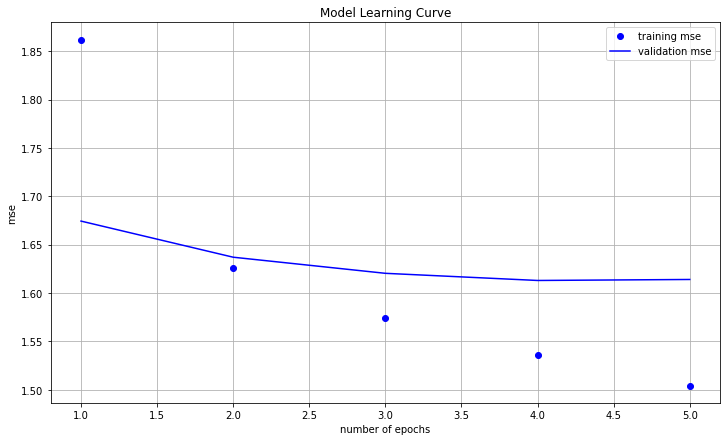

In [15]:
plot_learning_curve(history, 'mse')

In [16]:
# make prediction using test data
predictions = MLP_model.predict([ratings_test.user_id.values, ratings_test.anime_id.values])
# get the MSE
error = mse(ratings_test.rating.values, predictions)
print('The out-of-sample MSE of rating predictions is', round(error, 4))

The out-of-sample MSE of rating predictions is 1.612


In [17]:
def get_NeuMF_model(num_users, num_items, MF_dim, MF_reg, MLP_layers, MLP_regs):
    """
    Build Neural Matrix Factorization (NeuMF) Model Topology.
    This is stack version of both GMF and MLP
    
    Parameters
    ----------
    num_users: int, total number of users
    num_iterms: int, total number of items
    MF_dim: int, embedded dimension for user vector and item vector in MF
    MF_reg: tuple of float, L2 regularization of MF embedded layer
    MLP_layers: list of int, each element is the number of hidden units for each MLP layer,
        with the exception of first element. First element is the sum of dims of
        user latent vector and item latent vector
    MLP_regs: list of int, each element is the L2 regularization parameter for
        each layer in MLP

    Return
    ------
    A Keras Model with MLP model architeture
    """
    assert len(MLP_layers) == len(MLP_regs)
    num_MLP_layer = len(MLP_layers) # Number of layers in the MLP
    # Input variables
    user_input = Input(shape=(1,), dtype='int32', name='user_input')
    item_input = Input(shape=(1,), dtype='int32', name='item_input')

    # Embedding layer
    
    # MF
    MF_Embedding_User = Embedding(
        input_dim=num_users + 1,
        output_dim=MF_dim,
        embeddings_initializer='uniform',
        name='mf_user_embedding',
        embeddings_regularizer=l2(MF_reg[0]),
        input_length=1)
    MF_Embedding_Item = Embedding(
        input_dim=num_items + 1,
        output_dim=MF_dim,
        embeddings_initializer='uniform',
        name='mf_item_embedding',
        embeddings_regularizer=l2(MF_reg[1]),
        input_length=1)
    
    # MLP
    MLP_Embedding_User = Embedding(
        input_dim=num_users + 1,
        output_dim=MLP_layers[0] // 2,
        embeddings_initializer='uniform',
        name='mlp_user_embedding',
        embeddings_regularizer=l2(MLP_regs[0]),
        input_length=1)
    MLP_Embedding_Item = Embedding(
        input_dim=num_items + 1,
        output_dim=MLP_layers[0] // 2,
        embeddings_initializer='uniform',
        name='mlp_item_embedding',
        embeddings_regularizer=l2(MLP_regs[0]),
        input_length=1) 
    
    # MF part
    mf_user_latent = Flatten()(MF_Embedding_User(user_input))
    mf_item_latent = Flatten()(MF_Embedding_Item(item_input))
    mf_vector = Multiply()([mf_user_latent, mf_item_latent])

    # MLP part
    mlp_user_latent = Flatten()(MLP_Embedding_User(user_input))
    mlp_item_latent = Flatten()(MLP_Embedding_Item(item_input))
    mlp_vector = Concatenate(axis=-1)([mlp_user_latent, mlp_item_latent])
    for idx in range(1, num_MLP_layer):
        layer = Dense(
            units=MLP_layers[idx],
            activation='relu',
            kernel_initializer='glorot_uniform',
            kernel_regularizer=l2(MLP_regs[idx]),
            name = 'layer%d' %idx)
        mlp_vector = layer(mlp_vector)
    
    # Concatenate MF and MLP parts
    predict_vector = Concatenate(axis=-1)([mf_vector, mlp_vector])

    # Final prediction layer
    prediction = Dense(1, kernel_initializer='glorot_uniform', name='prediction')(predict_vector)
    
    # Stitch input and output
    model = Model([user_input, item_input], prediction)
    
    return model

In [18]:
NeuMF_model = get_NeuMF_model(
    num_users=num_users,
    num_items=num_items,
    MF_dim=10,
    MF_reg=(0, 0),
    MLP_layers=[64, 32, 16, 8],
    MLP_regs=[0, 0, 0, 0])
NeuMF_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user_input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
item_input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
mlp_user_embedding (Embedding)  (None, 1, 32)        2189504     user_input[0][0]                 
__________________________________________________________________________________________________
mlp_item_embedding (Embedding)  (None, 1, 32)        308256      item_input[0][0]                 
____________________________________________________________________________________________

In [19]:
# model config
BATCH_SIZE = 64
EPOCHS = 5
VAL_SPLIT = 0.25

# train model
history = train_model(NeuMF_model, 'adam', BATCH_SIZE, EPOCHS, VAL_SPLIT, 
                      inputs=[ratings_train.user_id.values, ratings_train.anime_id.values],
                      outputs=ratings_train.rating.values)

Epoch 1/5
51986/51986 [==============================] - 350s 7ms/step - loss: 1.8489 - mean_squared_error: 1.8489 - mse: 1.8489 - val_loss: 1.7200 - val_mean_squared_error: 1.7200 - val_mse: 1.7200
Epoch 2/5
51986/51986 [==============================] - 332s 6ms/step - loss: 1.5527 - mean_squared_error: 1.5527 - mse: 1.5528 - val_loss: 1.6139 - val_mean_squared_error: 1.6139 - val_mse: 1.6139
Epoch 3/5
51986/51986 [==============================] - 334s 6ms/step - loss: 1.4640 - mean_squared_error: 1.4640 - mse: 1.4640 - val_loss: 1.6125 - val_mean_squared_error: 1.6125 - val_mse: 1.6125
Epoch 4/5
51986/51986 [==============================] - 335s 6ms/step - loss: 1.4107 - mean_squared_error: 1.4107 - mse: 1.4107 - val_loss: 1.6229 - val_mean_squared_error: 1.6229 - val_mse: 1.6229
Epoch 5/5
51986/51986 [==============================] - 335s 6ms/step - loss: 1.3731 - mean_squared_error: 1.3731 - mse: 1.3731 - val_loss: 1.6287 - val_mean_squared_error: 1.6287 - val_mse: 1.6287


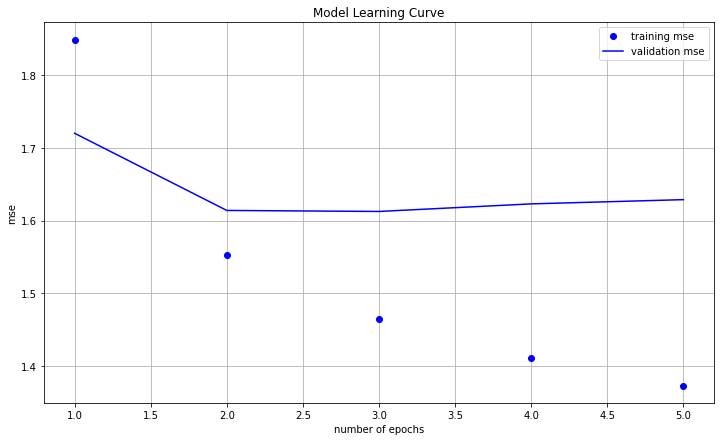

In [20]:
plot_learning_curve(history, 'mse')

In [21]:
# make prediction using test data
predictions = NeuMF_model.predict([ratings_test.user_id.values, ratings_test.anime_id.values])
# get the MSE
error = mse(ratings_test.rating.values, predictions)
print('The out-of-sample MSE of rating predictions is', round(error, 4))

The out-of-sample MSE of rating predictions is 1.6268
